[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Leo-ChenYZ/Explainable-AI/blob/main/Assignments/Assignment_4/Assignment_4.ipynb)

# Assignment 4
Leo Chen

In [21]:
!pip -q install torch torchvision timm pytorch-gradcam opendatasets kaggle matplotlib seaborn opencv-python

In [ ]:
!pip install --no-cache-dir "git+https://github.com/jacobgil/pytorch-grad-cam.git"

In [ ]:
from google.colab import files
import os, zipfile, shutil, glob
from pathlib import Path
import torch, random, numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from tqdm.auto import tqdm
import cv2, matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
# data
print("Upload kaggle.json (Kaggle API token).")
files.upload()

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!kaggle datasets download -d techsash/waste-classification-data -p /content/data
!unzip -q /content/data/waste-classification-data.zip -d /content/data
# The above code snippet was generated using GPT-5 on 10/04/25 at 4:20p.

Upload kaggle.json (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 98% 420M/427M [00:01<00:00, 305MB/s]
100% 427M/427M [00:01<00:00, 371MB/s]


In [5]:
train_dir = Path("/content/data/DATASET/TRAIN")
test_dir = Path("/content/data/DATASET/TEST")
assert train_dir.exists() and test_dir.exists(), "Check that /content/data/DATASET/TRAIN and TEST exist"

print("Train classes:", [p.name for p in sorted(train_dir.iterdir()) if p.is_dir()])
print("Test classes:", [p.name for p in sorted(test_dir.iterdir()) if p.is_dir()])

Train classes: ['O', 'R']
Test classes: ['O', 'R']


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "(set Colab to GPU: Runtime > Change runtime type > GPU)")

Device: cpu (set Colab to GPU: Runtime > Change runtime type > GPU)


In [9]:
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

In [10]:
# Transforms

img_size = 192

train_tfms = transforms.Compose([
transforms.Resize((img_size, img_size)),
transforms.RandomHorizontalFlip(0.5),
transforms.ColorJitter(0.2,0.2,0.2,0.1),
transforms.ToTensor(),
transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_tfms = transforms.Compose([
transforms.Resize((img_size, img_size)),
transforms.ToTensor(),
transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds_full = datasets.ImageFolder(train_dir, transform=train_tfms)
test_ds_full = datasets.ImageFolder(test_dir, transform=test_tfms)
class_names = train_ds_full.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['O', 'R']


In [11]:
def balanced_subset_indices(img_folder_ds, max_per_class):
    by_class = defaultdict(list)
    for i, (_, y) in enumerate(img_folder_ds.samples):
        by_class[y].append(i)
    indices = []
    for y, idxs in by_class.items():
        random.shuffle(idxs)
        indices.extend(idxs[:max_per_class])
    random.shuffle(indices)
    return indices

In [13]:
max_train_per_class = 100
max_test_per_class = 80  # evaluation subset

train_idx = balanced_subset_indices(train_ds_full, max_train_per_class)
test_idx = balanced_subset_indices(test_ds_full, max_test_per_class)

train_ds = Subset(train_ds_full, train_idx)
test_ds = Subset(test_ds_full, test_idx)

print(f"Subset sizes -> train: {len(train_ds)} | test: {len(test_ds)}")

Subset sizes -> train: 200 | test: 160


In [14]:
batch_size = 64 if device.type == "cuda" else 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=(device.type=="cuda"))
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(device.type=="cuda"))

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [15]:
# Freeze backbone for quick training
for name, p in model.named_parameters():
    if not name.startswith("fc."):
        p.requires_grad = False

# Replace final layer
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Only optimize the final layer
optimizer = optim.AdamW(model.fc.parameters(), lr=2e-3, weight_decay=1e-4)

# The above code snippet was generated using GPT-5 on 10/05/25 at 6:45p.

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def train_one_epoch(model, loader, optimizer, criterion, device, max_steps=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for step, (x, y) in enumerate(tqdm(loader, leave=False)):
        if max_steps is not None and step >= max_steps:
            break
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

/tmp/ipython-input-811968531.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [ ]:
epochs = 2
MAX_TRAIN_STEPS_PER_EPOCH = 150

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, max_steps=MAX_TRAIN_STEPS_PER_EPOCH)
    te_loss, te_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

torch.save(model.state_dict(), "/content/resnet50_waste_quick.pt")
# The above code snippet was generated using GPT-5 on 10/05/25 at 7:05p.

In [31]:
target_layers = [model.layer4[-1]]

def denorm(img_t):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_t.device).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_t.device).view(3,1,1)
    return (img_t * std) + mean

def tensor_to_rgb_np(img_t):
    return denorm(img_t).clamp(0,1).permute(1,2,0).detach().cpu().numpy()

@torch.no_grad()
def predict(model, img_t):
    logits = model(img_t.unsqueeze(0).to(device))
    probs = logits.softmax(dim=1)[0].detach().cpu().numpy()
    return int(probs.argmax()), probs

def run_all_cams_on_image(model, img_t, methods=("gradcam","gradcampp","scorecam")):
    model.eval()
    input_tensor = img_t.unsqueeze(0).to(device)
    pred_idx, probs = predict(model, img_t)
    rgb_img = tensor_to_rgb_np(img_t)

    outputs = {}

    # Temporarily enable gradients for target layers
    original_requires_grad = {}
    for layer in target_layers:
        for p in layer.parameters():
            if p.requires_grad == False:
                original_requires_grad[p] = False
                p.requires_grad = True

    try:
        if "gradcam" in methods:
            cam = GradCAM(model=model, target_layers=target_layers)
            gc = cam(input_tensor=input_tensor, targets=None)
            outputs["Grad-CAM"] = show_cam_on_image(rgb_img, gc[0], use_rgb=True)

        if "gradcampp" in methods:
            cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
            gpp = cam(input_tensor=input_tensor, targets=None)
            outputs["Grad-CAM++"] = show_cam_on_image(rgb_img, gpp[0], use_rgb=True)

        if "scorecam" in methods:
            cam = ScoreCAM(model=model, target_layers=target_layers)
            sc = cam(input_tensor=input_tensor, targets=None)
            outputs["Score-CAM"] = show_cam_on_image(rgb_img, sc[0], use_rgb=True)
    finally:
        # Restore original requires_grad settings
        for p, requires_grad in original_requires_grad.items():
            p.requires_grad = requires_grad

    return pred_idx, probs, outputs

def show_results(img_paths, n_images=5):
    sel = img_paths[:n_images]
    for p in sel:
        img = cv2.imread(str(p))[:, :, ::-1]
        img = cv2.resize(img, (img_size, img_size))
        img_t = test_tfms(transforms.ToPILImage()(img))
        pred_idx, probs, overlays = run_all_cams_on_image(model, img_t)

        cols = len(overlays)+1
        fig, axs = plt.subplots(1, cols, figsize=(4*cols, 4))
        if cols == 2:
            axs = [axs[0], axs[1]]
        axs[0].imshow(img); axs[0].axis("off")
        axs[0].set_title(f"Original\nPred: {class_names[pred_idx]}")
        for j, (k, v) in enumerate(overlays.items()):
            axs[j+1].imshow(v); axs[j+1].axis("off"); axs[j+1].set_title(k)
        plt.tight_layout(); plt.show()
        # The above code snippet was generated using GPT-5 on 10/05/25 at 9:50p.

paths = []
for cls in class_names:
    cls_folder = test_dir / cls
    imgs = sorted([p for p in cls_folder.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp"]])
    paths.extend(imgs[:5])

100%|██████████| 128/128 [05:08<00:00,  2.41s/it]


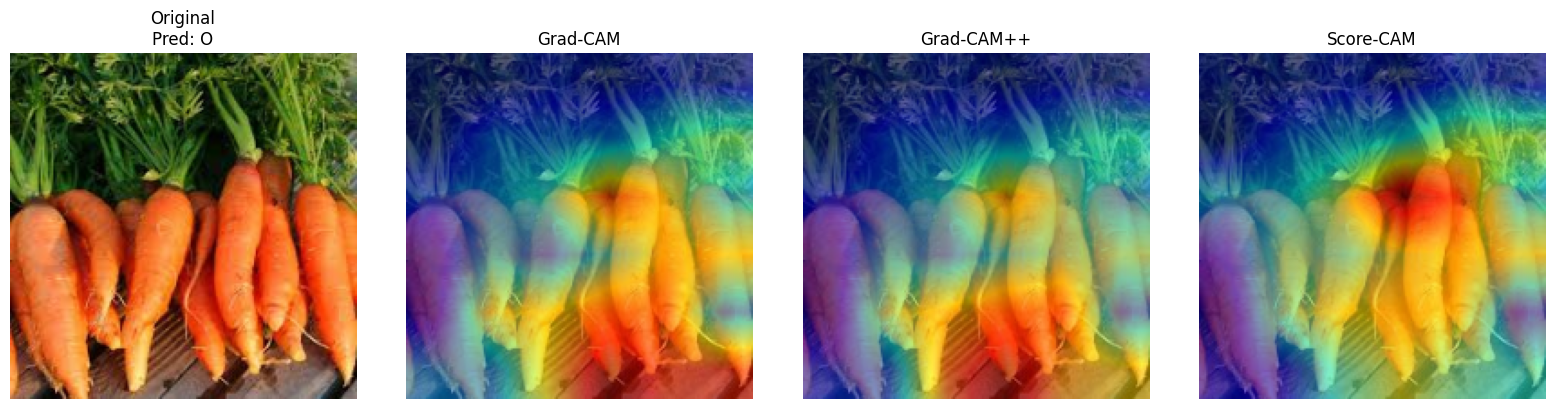

100%|██████████| 128/128 [05:04<00:00,  2.38s/it]


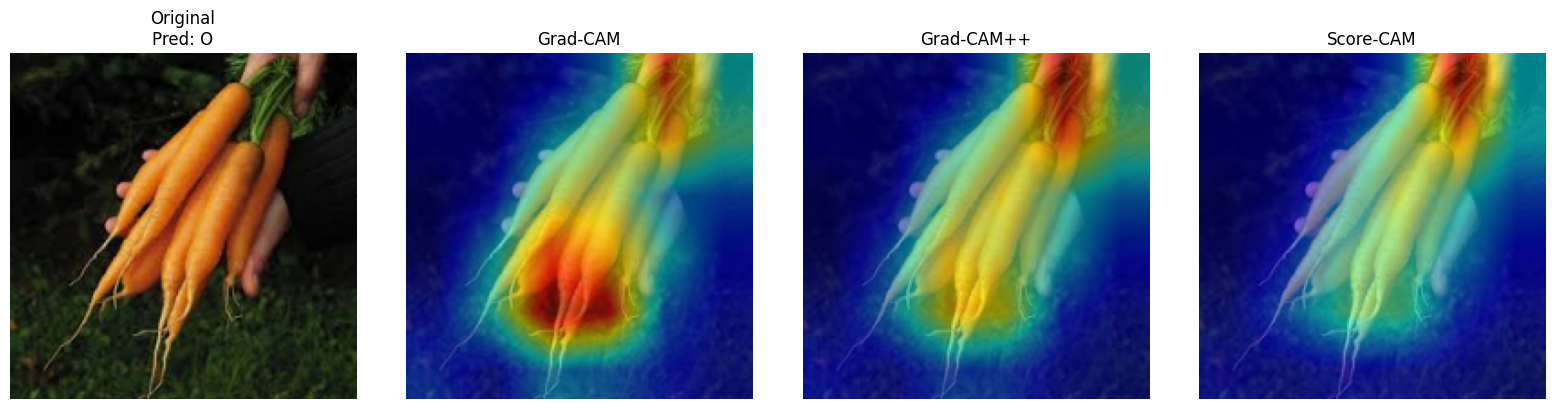

100%|██████████| 128/128 [05:10<00:00,  2.43s/it]


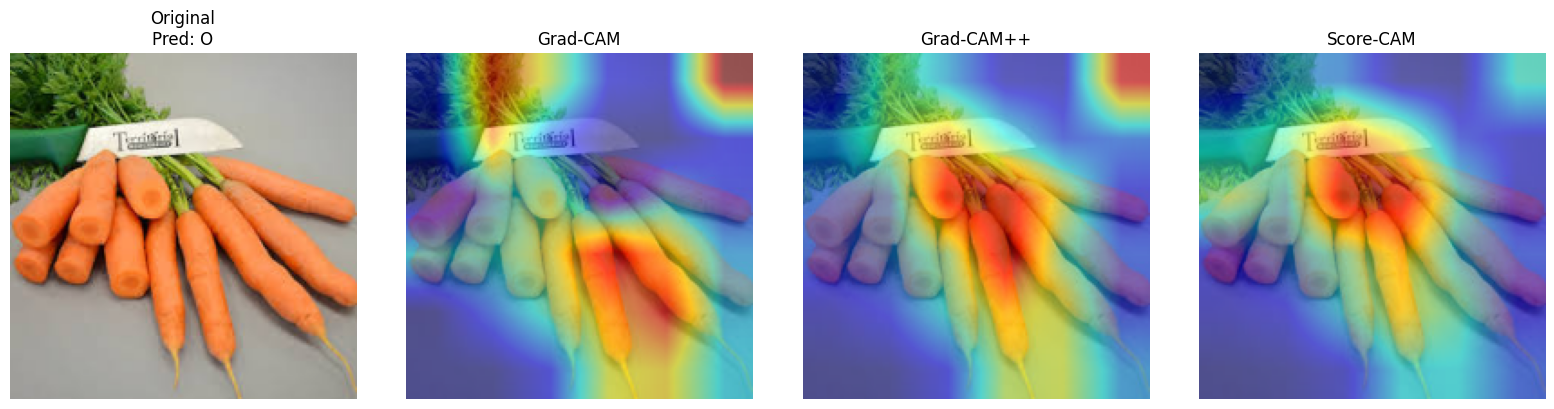

100%|██████████| 128/128 [05:24<00:00,  2.54s/it]


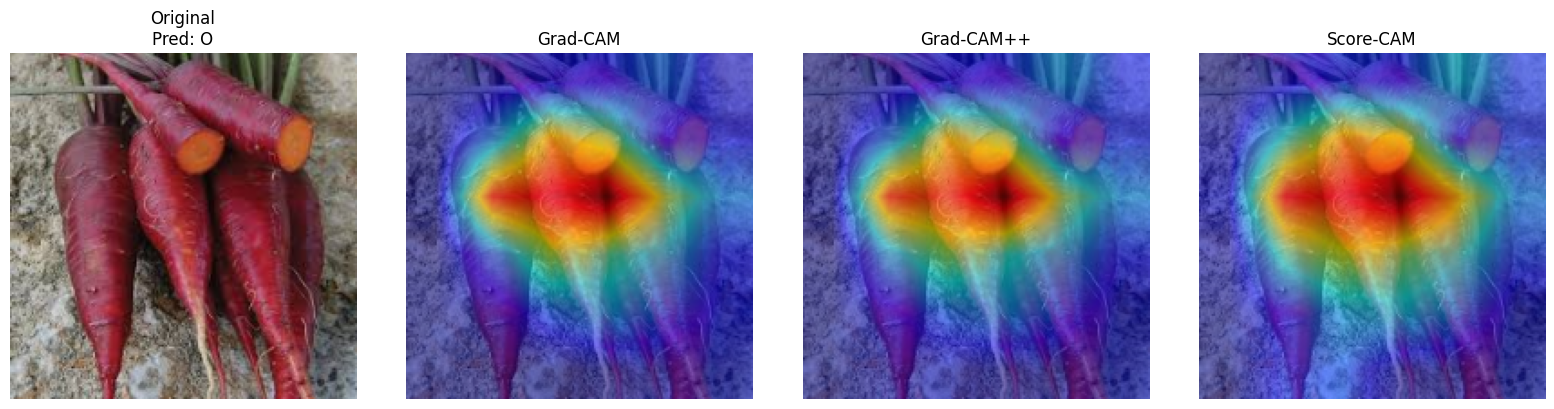

100%|██████████| 128/128 [06:16<00:00,  2.94s/it]


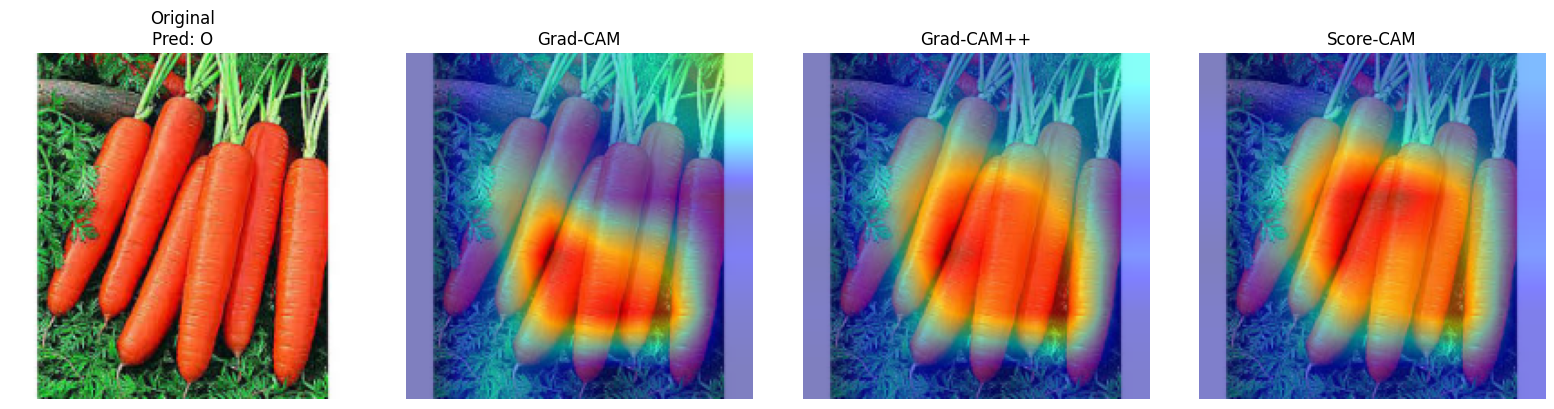

In [32]:
show_results(paths, n_images=5)

Across these examples, all three methods broadly agree that the model bases its "O" predictions on the carrot bodies, but they differ in sharpness and coverage. Grad-CAM gives the coarsest maps and occasionally drifts to background or distractors (e.g., the upper corner and the knife), showing large, blob-like hotspots. Grad-CAM++ tends to be more precise and instance-aware: it sharpens the focus along the carrot shafts and tips and better separates adjacent carrots in crowded scenes. Score-CAM produces smoother, more contiguous coverage of the carrots with less background noise than Grad-CAM, often highlighting the full extent of the salient carrots rather than just the most activated cores—though it can slightly spill into nearby regions.

Across images the model keyes in on mid-level cues that are highly diagnostic for organics: elongated carrot geometry, the orange spectral range, longitudinal ridges, and tip/leaf boundaries; Grad-CAM++ often concentrates on tips and edges while Score-CAM spreads across the full body, implying both boundary- and surface-based evidence. Some behaviors are surprising: bright, high-contrast distractors (knife blades, hands, glossy highlights) and repeated background patterns (cutting boards, soil texture, studio corners) sometimes attract heat, hinting at spurious correlations and color/context shortcuts. This matters in waste sorting because such shortcuts can cause systematic errors—e.g., orange plastic packaging being classified as organic or muddy recyclables being misrouted—raising contamination rates and downstream costs. Explainability makes these failure modes visible, letting us act: collect hard negatives (orange plastic in “R”), randomize backgrounds, boost texture-invariant augmentations, and add segmentation or ROI detection to suppress context. It also supports operational safeguards like confidence-based abstention for manual review, calibrating thresholds, or supplementing with additional sensors (depth/multispectral) where color is ambiguous. Beyond accuracy, transparent attention maps build operator trust, enable audits, and provide evidence for model updates, which is critical in sustainability workflows where mistakes can have huge economic and environmental impact.